## **Libraries to be installed beforehand**

In [1]:
# !pip3 install openpyxl
# !pip3 install xlrd

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import string
import pickle
import xlrd

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier


## **Importing dataset**

Reading dataset using openpyxl engine since xlrd is now discontinued

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
dataset = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
# dataset = pd.read_excel('dataset.xlsx')

In [5]:
dataset.head()

,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


### **Cleaning and analysing dataset and its sturcture**

In [6]:
dataset.isnull().sum()

URL          0
Text         0
Sentiment    0
dtype: int64

In [7]:
dataset.drop('URL', axis='columns', inplace=True)

In [8]:
dataset.head()

,Text,Sentiment
0,Girlfight follows a project dwelling New York ...,POS
1,Hollywood North is an euphemism from the movie...,POS
2,That '70s Show is definitely the funniest show...,POS
3,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,"A series of random, seemingly insignificant th...",POS


In [9]:
print(f'Rows: {dataset.shape[0]}\nColumns: {dataset.shape[1]}')
print(f'Columns Names: {list(dataset.columns)}')

Rows: 1999
Columns: 2
Columns Names: ['Text', 'Sentiment']


### **Tokenization of sentences**


In [10]:
nlp = English()
stopwords = list(STOP_WORDS)
punctuations = string.punctuation

In [11]:
def tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

### **Transform and vectorization**

In [12]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()

In [13]:
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 
tfvectorizer = TfidfVectorizer(tokenizer = tokenizer)

### **Dataset splitting**

In [14]:
X = dataset['Text']
y = dataset['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [15]:
def generate_report(pred_list, custom_model, model_name):
  print(f'Confusion Matrix:\n{confusion_matrix(y_test,pred_list)}')
  print(f'\nClassification Report:\n{classification_report(y_test,pred_list)}')
  acc = accuracy_score(y_test, pred_list) * 100
  print(f'Accuracy: {acc}%')
  prec = precision_score(y_test, pred_list, average='macro') * 100
  print(f'Precision: {prec}%')
  rec = recall_score(y_test, pred_list, average='macro') * 100
  print(f'Recall: {rec}%')
  pickle.dump(custom_model, open(model_name + '.sav', 'wb'))
  print(model_name + ' trained Model Saved')
  return acc, prec, rec

## **Bernoulli Naïve Bayes (BNB)**

In [16]:
from sklearn.naive_bayes import BernoulliNB

In [17]:
classifier = BernoulliNB()
BNBmodel = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', classifier)])

BNBmodel.fit(X_train,y_train)
BNBpred=BNBmodel.predict(X_test)

In [18]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(BNBpred, BNBmodel, 'BernoulliNB_model')

Confusion Matrix:
[[173  22]
 [ 32 173]]

Classification Report:
              precision    recall  f1-score   support

         NEG       0.84      0.89      0.87       195
         POS       0.89      0.84      0.87       205

    accuracy                           0.86       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.86      0.86       400

Accuracy: 86.5%
Precision: 86.55409631019386%
Recall: 86.55409631019386%
BernoulliNB_model trained Model Saved


## **Multinomial Naïve Bayes (MNB)**

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
classifier = MultinomialNB()
MNBmodel = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', classifier)])

#train the model
MNBmodel.fit(X_train,y_train)
MNBpred=MNBmodel.predict(X_test)

In [21]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(MNBpred, MNBmodel, 'MultinomialNB_model')

Confusion Matrix:
[[171  24]
 [ 34 171]]

Classification Report:
              precision    recall  f1-score   support

         NEG       0.83      0.88      0.85       195
         POS       0.88      0.83      0.85       205

    accuracy                           0.85       400
   macro avg       0.86      0.86      0.85       400
weighted avg       0.86      0.85      0.85       400

Accuracy: 85.5%
Precision: 85.55347091932457%
Recall: 85.55347091932457%
MultinomialNB_model trained Model Saved


In [22]:
# Another random review
pre = BNBmodel.predict(["Production has an incredibly important place to shoot a series or film. Sometimes even a very minimalist story can reach an incredibly successful point after the right production stages. The Witcher series is far from minimalist. The Witcher is one of the best Middle-earth works in the world. Production quality is essential if you want to handle such a topic successfully."])
print(f'Prediction: {pre[0]}')

Prediction: POS


## **Maximum Entropy (ME)**

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
classifier = LogisticRegression()
LRmodel = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', classifier)])

# Train the Model
LRmodel.fit(X_train,y_train)   
LRpred = LRmodel.predict(X_test)

In [25]:
lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(LRpred, LRmodel, 'LinearRegression_model')

Confusion Matrix:
[[169  26]
 [ 34 171]]

Classification Report:
              precision    recall  f1-score   support

         NEG       0.83      0.87      0.85       195
         POS       0.87      0.83      0.85       205

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

Accuracy: 85.0%
Precision: 85.02663099197319%
Recall: 85.04065040650406%
LinearRegression_model trained Model Saved


In [26]:
# Another random review
pre = LRmodel.predict(["Production has an incredibly important place to shoot a series or film. Sometimes even a very minimalist story can reach an incredibly successful point after the right production stages. The Witcher series is far from minimalist. The Witcher is one of the best Middle-earth works in the world. Production quality is essential if you want to handle such a topic successfully."])
print(f'Prediction: {pre[0]}')

Prediction: POS


## **Decision Tree (DE)**

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [28]:
dt_clf = DecisionTreeClassifier()
dt_model = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', dt_clf)])

# Train the Model
dt_model.fit(X_train,y_train)   
dt_pred = dt_model.predict(X_test)

In [29]:
dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(dt_pred, dt_model, 'DecisionTree_model')

Confusion Matrix:
[[172  23]
 [ 50 155]]

Classification Report:
              precision    recall  f1-score   support

         NEG       0.77      0.88      0.82       195
         POS       0.87      0.76      0.81       205

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Accuracy: 81.75%
Precision: 82.27806458143536%
Recall: 81.90744215134458%
DecisionTree_model trained Model Saved


In [30]:
# Another random review
pre = dt_model.predict(["Production has an incredibly important place to shoot a series or film. Sometimes even a very minimalist story can reach an incredibly successful point after the right production stages. The Witcher series is far from minimalist. The Witcher is one of the best Middle-earth works in the world. Production quality is essential if you want to handle such a topic successfully."])
print(f'Prediction: {pre[0]}')

Prediction: POS


## **Support Vector Machine (SVM)**

In [31]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report
# pipeline and standard scalar are already imported

In [32]:
%%time
#Train the model
# Perform classification with SVM, kernel=linear
SVMclassifier = svm.SVC(kernel='linear')
SVMmodel = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', SVMclassifier)])
SVMmodel.fit(X_train,y_train)
SVMpred = SVMmodel.predict(X_test)

CPU times: user 2min 11s, sys: 2.01 s, total: 2min 13s
Wall time: 2min 13s


In [33]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(SVMpred, SVMmodel, 'SVM_model')

Confusion Matrix:
[[168  27]
 [ 33 172]]

Classification Report:
              precision    recall  f1-score   support

         NEG       0.84      0.86      0.85       195
         POS       0.86      0.84      0.85       205

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

Accuracy: 85.0%
Precision: 85.00712517812946%
Recall: 85.02814258911819%
SVM_model trained Model Saved


In [34]:
# Another random review
pre = SVMmodel.predict(["Production has an incredibly important place to shoot a series or film. Sometimes even a very minimalist story can reach an incredibly successful point after the right production stages. The Witcher series is far from minimalist. The Witcher is one of the best Middle-earth works in the world. Production quality is essential if you want to handle such a topic successfully."])
print(f'Prediction: {pre[0]}')

Prediction: POS


## **Results comparision plots and tables**

In [35]:
!pip3 install tabulate
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'], 
         ['Multinomial Naïve Bayes', mnb_metrics[0], mnb_metrics[1], mnb_metrics[2]], 
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name              │   Accuracy │   Precision │   Recall │
╞═════════════════════════╪════════════╪═════════════╪══════════╡
│ Multinomial Naïve Bayes │      85.5  │     85.5535 │  85.5535 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Bernoulli Naïve Bayes   │      86.5  │     86.5541 │  86.5541 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine  │      85    │     85.0071 │  85.0281 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy         │      85    │     85.0266 │  85.0407 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree           │      81.75 │     82.2781 │  81.9074 │
╘═════════════════════════╧════════════╧═════════════╧══════════╛


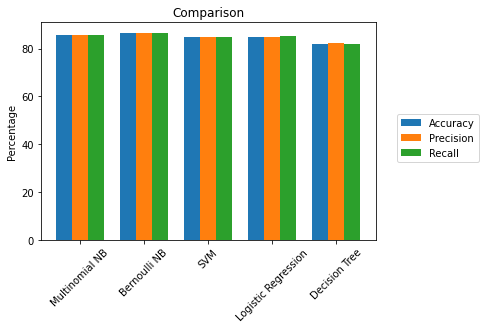

In [36]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 5
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()

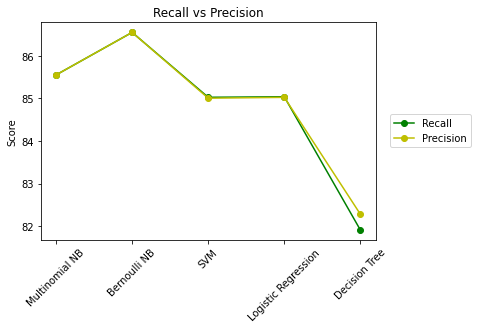

In [37]:
import matplotlib.pyplot as plt
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree']
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
precision = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()